# Objects

Have a look at the [Hybrd system simulation](Hybrid%20system%20simulation.ipynb) notebook before reading this one.

In the `for` loop we used to implement the Euler integration in that notebook, it was clear that we were working with two systems - the tank system and the controller. We can see some similarities between the two systems: both of them have an input ($x$ for the tank, $e$ for the controller) and an output ($h$ for the tank, $x$ for the controller), both of them have an internal state ($V$ and the integral of the error). However, we ended up having to repeat many calculations for the two of them, and the code corresponding to the two systems ended up in different places between the two of them.

Objects allow us to group each system's equations and data together so that our loop can be cleaner and the parts of the code that are specific to each system can be all in one place.

In [17]:
import numpy
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

## Tank system

We start by defining a `class` for the tank system:

In [18]:
class TankSystem:
    def __init__(self, A, alpha, K, V, Fi):
        """ This special function gets called when an object of this class is created"""
        self.A = A
        self.alpha = alpha
        self.K = K
        self.Fi = Fi
        self.change_state(V)
    
    def f(self, x):
        return self.alpha**(x - 1)
    
    def change_input(self, x):
        self.Fo = self.K*self.f(x)*numpy.sqrt(self.h)
        
    def change_state(self, V):
        self.state = self.V = V
        self.output = self.h = self.V/self.A

    def derivative(self, x):
        self.change_input(x)
        dVdt = self.Fi - self.Fo
        return dVdt

The functions defined inside the class are known as `methods` and are called as `object.method(arguments)`. You may imagine that `object.method(arguments)` gets translated to `method(object, arguments)` before it is called, so the `self` argument to methods will be the object whose method is called.

## PI Controller

And another for the PI controller.

In [19]:
class PIController:
    def __init__(self, Kc, tau_i, bias):
        self.Kc = Kc
        self.G = scipy.signal.lti([Kc*tau_i, Kc], [tau_i, 0])
        self.Gss = self.G.to_ss()
        self.change_state(numpy.zeros((self.Gss.A.shape[0], 1)))
        self.bias = self.output = bias
        self.y = self.bias
        
    def change_input(self, u):
        self.y = self.Gss.C.dot(self.x) + self.Gss.D.dot(u) + self.bias
        self.output = self.y[0, 0]  # because y is a matrix, and we want a scalar output
    
    def change_state(self, x):
        self.x = self.state = x
    
    def derivative(self, e):
        return self.Gss.A.dot(self.x) + self.Gss.B.dot(e)

In [20]:
ts = numpy.linspace(0, 100, 1000)
dt = ts[1]

In [21]:
sp = 1.3

## Generic integration

Now we can integrate. Notice that in the code below there is no specific reference to tanks or PI controllers. To change the type of controller or the system, we can change the kinds of objects we create as `system` and `controller`

In [22]:
def control_simulation(system, controller):
    outputs = []
    for t in ts:
        system.change_input(controller.output)

        e = sp - system.output

        controller.change_input(e)

        system.change_state(system.state + system.derivative(controller.output)*dt)
        controller.change_state(controller.state + controller.derivative(e)*dt)

        outputs.append(system.output)
    return outputs

In [23]:
system = TankSystem(A=2, alpha=20, K=2, V=2, Fi=1)
controller = PIController(Kc=-1, tau_i=5, bias=0.7)

In [24]:
outputs = control_simulation(system, controller)

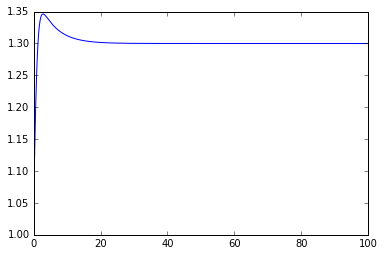

In [25]:
plt.plot(ts, outputs)

This allows us to simulate different situations easily.

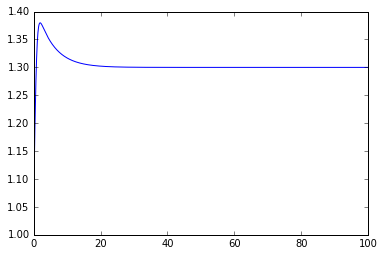

In [26]:
outputs = control_simulation(system=TankSystem(A=2, alpha=10, K=2, V=2, Fi=1), 
                             controller=PIController(Kc=-2, tau_i=5, bias=0.5))
plt.plot(ts, outputs);

## Re-using the interface

Note that we could also define a completely new system. The controller doesn't "know" it is a level controller in this case, so let's build a class which would represent an LTI system under control:

In [27]:
class LtiSystem:
    def __init__(self, numerator, denominator):
        self.G = scipy.signal.lti(numerator, denominator)
        self.Gss = self.G.to_ss()
        self.change_state(numpy.zeros((self.Gss.A.shape[0], 1)))
        self.y = self.output = 0
        
    def change_input(self, u):
        self.y = self.Gss.C.dot(self.x) + self.Gss.D.dot(u)
        self.output = self.y[0, 0]
    
    def change_state(self, x):
        self.x = self.state = x
    
    def derivative(self, e):
        return self.Gss.A.dot(self.x) + self.Gss.B.dot(e)

Now we can simulate the response of an arbitrary LTI system to an arbitrary controller as long as we have classes to represent their behaviour!

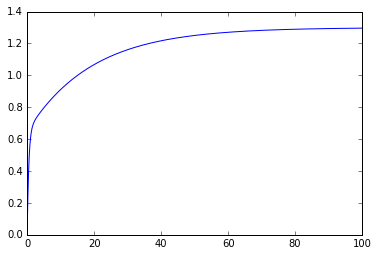

In [28]:
outputs = control_simulation(system=LtiSystem(1, [1, 1]), 
                             controller=PIController(Kc=1, tau_i=10, bias=0))
plt.plot(ts, outputs)

Look how easy it becomes to compare control performance:

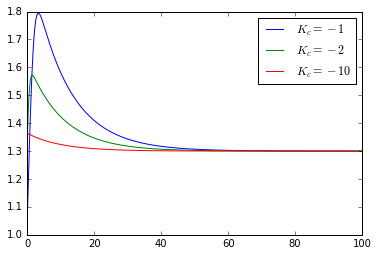

In [32]:
system = TankSystem(A=2, alpha=10, K=2, V=2, Fi=1)

controllers = [PIController(Kc=K, tau_i=10, bias=0) for K in [-1, -2, -10]]
for controller in controllers:
    outputs = control_simulation(system, controller)
    plt.plot(ts, outputs, label=r'$K_c={}$'.format(controller.Kc))
plt.legend()